# **Executive Summary of Project:**
  - Consolidate all reviews to rate each aspect of a restaurant, if the rating is too low or high, our code can automatically generate a comment to consolidate the majority of reviews on the rating. To establish market trends based on the customer data available to us, which will help the restaurants to identify focus areas based on current customer preference
Subsequently, identify specific aspects that can help improve the restaurant's services by assessing ratings for different aspects such as food, service, ambiance, etc. If a low rating is detected for a particular aspect (e.g., food), the code will further analyze the reviews to pinpoint specific dishes that need improvement and suggest ways to enhance them. This approach aims to provide actionable insights for restaurants to enhance customer satisfaction and overall service quality.

# **Data Sources:**
  - yelp_academic_dataset_business.json
  - yelp_academic_dataset_review.json

# **filtering/selection criteria**

In the Yelp dataset, we have access to numerous restaurants and businesses from different regions. By analyzing the reviews collected on the website, we can evaluate these restaurants and businesses. To eliminate regional biases in this project, we will focus solely on restaurants in Arizona. Through this analysis of reviews, we aim to identify the strengths and areas for improvement of Arizona's restaurants. Besides filtering by region, to ensure a more accurate analysis of the reviews, we've decided to include only those restaurants that are still operational. Additionally, we will concentrate on restaurants with more than 200 reviews to avoid the influence of outliers that might skew the overall trend. We believe that past data might not accurately reflect the current situation of restaurants; therefore, we will only select reviews from 2019 onwards for our analysis.


### **Final selection criteria:**

1.Restaurants located in Arizona.

2.Restaurants that are still in operation.

3.Restaurants with a total number of reviews greater than 200.

4.Only reviews from 2019 onwards are selected for analysis.

In [6]:
!pip install vaderSentiment


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.0/126.0 kB 5.3 MB/s eta 0:00:00


In [7]:
# Import necessary libraries
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [8]:
# File paths for each dataset
business_file_path = '/content/drive/MyDrive/yelp_academic_dataset_business.json'
review_file_path = '/content/drive/MyDrive/yelp_academic_dataset_review.json'
df = pd.read_json(business_file_path, lines=True)

In [9]:
business_df = pd.read_json(business_file_path, lines=True)
# Filter business IDs for Restaurants in Arizona and fit other filtered condition we set
restaurant_business_ids_az = business_df.dropna(subset=['categories', 'state'])
restaurant_business_ids_az = restaurant_business_ids_az[
    (restaurant_business_ids_az['categories'].apply(lambda x: 'Restaurants' in x)) &
    (restaurant_business_ids_az['state'] == 'AZ')&
    (restaurant_business_ids_az['is_open'] == 1) &
    (restaurant_business_ids_az['review_count'] > 200)
]['business_id']

In [10]:
# Extract the reviews are from those restaurants
chunk_size = 10000
filtered_reviews = pd.DataFrame()

for chunk in pd.read_json(review_file_path, lines=True, chunksize=chunk_size):
    filtered_chunk = chunk[chunk['business_id'].isin(restaurant_business_ids_az)]
    filtered_reviews = pd.concat([filtered_reviews, filtered_chunk], ignore_index=True)


In [11]:
# Shoe how many restaurants in fit our conditions and how many reviews from these restaurants
filtered_business_count = len(restaurant_business_ids_az)
filtered_reviews_count = len(filtered_reviews)
print(f"Filtered restaurant count: {filtered_business_count}")
print(f"Filtered reviews count: {filtered_reviews_count}")

print(filtered_reviews.head())

Filtered restaurant count: 315
Filtered reviews count: 128877
                review_id                 user_id             business_id  \
0  UBp0zWyH60Hmw6Fsasei7w  4Uh27DgGzsp6PqrH913giQ  otQS34_MymijPTdNBoBdCw   
1  jlvaJo1I56NrZ1Q1CUuuRw  17jzGkFYCvB5Q0fjJEzVAA  otQS34_MymijPTdNBoBdCw   
2  f7fAYGJpd4gZAoJxuJcciw  LpZfJekvMo5S61UBAmuyHw  cXAKeC-EgVChIxhS7fscmw   
3  b0AI6U9CCWpFKI3iPLYiow  _l0csyXqNIcb3vG-1qR8DQ  UCMSWPqzXjd7QHq7v8PJjQ   
4  chtDBb_3unH0Wcs3W2Iahw  gSp5C3BfIVAHdH27rzoCDQ  RhuYqAT45uIR2NNdDsolXQ   

   stars  useful  funny  cool  \
0      4       0      2     0   
1      4       0      0     0   
2      5       2      0     0   
3      4       0      0     0   
4      5       1      0     1   

                                                text                date  
0  The bun makes the Sonoran Dog. It's like a snu... 2011-10-27 17:12:05  
1  I was told this place is a must for a Sonoran ... 2017-06-17 17:17:29  
2  The food at Ghini's is just delicious. Everyth..

In [12]:
# filter the review after 2019

filtered_reviews['date'] = pd.to_datetime(filtered_reviews['date'])

filtered_reviews_after_2019 = filtered_reviews[filtered_reviews['date'] > '2019-01-01']

print(f"Filtered reviews count after 2019: {len(filtered_reviews_after_2019)}")
print(filtered_reviews_after_2019.head())


Filtered reviews count after 2019: 40151
                   review_id                 user_id             business_id  \
4096  o21Vkq6AGh51jd1aE5jneA  G4My7ocIUlFXA0G1dMcQBQ  -y5vYOsyL4bSFxeOtQtYbg   
4253  kIqFgvfLAcw79HQ9XrGt6w  kjqtKg38NwHAeaq5Fjc5CA  UCMSWPqzXjd7QHq7v8PJjQ   
4319  i6B0syPgvDRsbC3BoQAP0Q  R3jqRDnxR0OnsBPHvp49hw  XyGRDrgCK0z4CiA6nhwEaw   
4320  aIeYCh7CbLKNsQbXi47r0Q  1h40OGNNcZ0nrrdJh4PEww  XyGRDrgCK0z4CiA6nhwEaw   
4322  i-o2OTun3sVEI5GCP1ZKZQ  hSUgs37OCwU0QZVVjSB0gw  wJmyu7W1K9A_gE8Ed4Bc9w   

      stars  useful  funny  cool  \
4096      5       0      0     1   
4253      5       0      0     0   
4319      5       0      1     0   
4320      5       1      0     0   
4322      5       0      0     0   

                                                   text                date  
4096  Fabulous place! So much better than Whole Food... 2019-01-17 23:29:41  
4253  This place puts Tucson breakfast on the map! I... 2019-03-14 19:26:55  
4319  So happy that Tucson 

In [37]:
print(filtered_reviews_after_2019['text'].head(200))

4096                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                    

# **Summary Statistics of the Data**
- Number of reviews:40151
- Total number of tokens:4076727
- Number of unique words (i.e., size of vocabulary):51846
- Average review length (i.e., average number of words of each review):88.58571392991458
- Number of unique customers:21388
- Other key elements involved
  - number of businesses/regions covered: AZ
  - average stars per review:3.54
  - distribution of stars:
    - 1:    12385
    - 2:    10694
    - 3:    13806
    - 4:    30552
    - 5:    61440

In [13]:
# find number of reviews, total number of tokens, number of unique words (i.e., size of vocabulary) **
import nltk
from nltk.tokenize import word_tokenize

nltk.download('punkt')

all_text = " ".join(filtered_reviews_after_2019['text'])

tokens = word_tokenize(all_text)

total_tokens = len(tokens)

unique_words = set(tokens)
vocabulary_size = len(unique_words)

print(f"Filtered reviews count after 2019: {len(filtered_reviews_after_2019)}")
print(f"Total number of tokens: {total_tokens}")
print(f"Size of vocabulary: {vocabulary_size}")


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


Filtered reviews count after 2019: 40151
Total number of tokens: 4076727
Size of vocabulary: 51846


In [14]:
# Average review length
filtered_reviews_after_2019['word_count'] = filtered_reviews_after_2019['text'].apply(lambda x: len(x.split()))
average_review_length = filtered_reviews_after_2019['word_count'].mean()

print(f"Average review length (in words): {average_review_length}")

Average review length (in words): 88.58571392991458


<ipython-input-14-f3c0ce46104d>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_reviews_after_2019['word_count'] = filtered_reviews_after_2019['text'].apply(lambda x: len(x.split()))


In [15]:
# Number of unique customers

unique_customers_count = filtered_reviews_after_2019['user_id'].nunique()

print(f"Number of unique customers: {unique_customers_count}")

Number of unique customers: 21388


## **Business Data exploration**
### In this part we will delve in business dataset and try to find uf there have any tren in Arizona resturant

In [16]:
import pandas as pd
import json

# Function to load a file where each line is a separate JSON object
def load_json_to_df(filepath):
    with open(filepath, 'r', encoding='utf-8') as file:
        data = [json.loads(line) for line in file]
    return pd.DataFrame(data)

df = load_json_to_df(business_file_path)

# Display the DataFrame information
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150346 entries, 0 to 150345
Data columns (total 14 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   business_id   150346 non-null  object 
 1   name          150346 non-null  object 
 2   address       150346 non-null  object 
 3   city          150346 non-null  object 
 4   state         150346 non-null  object 
 5   postal_code   150346 non-null  object 
 6   latitude      150346 non-null  float64
 7   longitude     150346 non-null  float64
 8   stars         150346 non-null  float64
 9   review_count  150346 non-null  int64  
 10  is_open       150346 non-null  int64  
 11  attributes    136602 non-null  object 
 12  categories    150243 non-null  object 
 13  hours         127123 non-null  object 
dtypes: float64(3), int64(2), object(9)
memory usage: 16.1+ MB


In [17]:
# Assuming df is the DataFrame you have already loaded with the Yelp data

# Filter the DataFrame for businesses in Arizona (AZ)
df_az = df[df['state'] == 'AZ']

# Check how many businesses there are in Tempe, AZ and nearby cities
cities_near_tempe = ['Tempe', 'Scottsdale', 'Mesa', 'Chandler', 'Phoenix']
df_tempe_nearby = df_az[df_az['city'].isin(cities_near_tempe)]

# Output the counts for the whole state of AZ and for Tempe + nearby cities
count_az = df_az.shape[0]
count_tempe_nearby = df_tempe_nearby.shape[0]

print(f"Total businesses in Arizona: {count_az}")
print(f"Total businesses in Tempe and nearby cities: {count_tempe_nearby}")

# Determine if the data is sufficient
# Define a threshold for 'sufficient' data, for example 100
sufficient_threshold = 100
if count_tempe_nearby >= sufficient_threshold:
    print("Data for Tempe and nearby cities is sufficient for analysis.")
else:
    print("Data for Tempe and nearby cities is not sufficient for detailed analysis.")


Total businesses in Arizona: 9912
Total businesses in Tempe and nearby cities: 0
Data for Tempe and nearby cities is not sufficient for detailed analysis.


In [18]:
# Assuming df_az is the DataFrame containing businesses in Arizona

# Extract rows where 'categories' contains 'Restaurants'
df_restaurants_az = df_az[df_az['categories'].str.contains('Restaurants', na=False)]

# Group by the 'city' column and count the number of restaurants in each city
restaurant_counts_by_city = df_restaurants_az['city'].value_counts()

# Print the counts of restaurants in each city
print(restaurant_counts_by_city)

# You can also examine if there are cities with an unusually low number of restaurants
print(restaurant_counts_by_city[restaurant_counts_by_city < 5])  # Example threshold


Tucson              2466
Oro Valley            80
Marana                39
Green Valley          26
Sahuarita             17
Vail                  16
Catalina               7
Tuscon                 5
Mount Lemmon           4
TUCSON                 2
South Tucson           2
Picture Rocks          1
Corona De Tucson       1
Casas Adobes           1
Valencia West          1
Drexel Heights         1
tucson                 1
Corona de Tucson       1
Name: city, dtype: int64
Mount Lemmon        4
TUCSON              2
South Tucson        2
Picture Rocks       1
Corona De Tucson    1
Casas Adobes        1
Valencia West       1
Drexel Heights      1
tucson              1
Corona de Tucson    1
Name: city, dtype: int64


In [19]:
stars_distribution = filtered_reviews['stars'].value_counts().sort_index()

print("Review counts by stars:")
print(stars_distribution)

Review counts by stars:
1    12385
2    10694
3    13806
4    30552
5    61440
Name: stars, dtype: int64


In [20]:
# Calculate the overall average rating of restaurants in AZ
average_rating_az = df_restaurants_az['stars'].mean()

# Group by 'city' and calculate the average rating for each city
average_rating_by_city = df_restaurants_az.groupby('city')['stars'].mean().sort_values(ascending=False)

# Output the overall average rating for AZ
print(f"Overall average rating of restaurants in AZ: {average_rating_az:.2f}")

# Output the average rating for the top 5 cities by average rating
print("Top 5 cities by average restaurant rating:")
print(average_rating_by_city.head(10))

# Output the average rating for the bottom 5 cities by average rating
print("\nBottom 5 cities by average restaurant rating:")
print(average_rating_by_city.tail(10))


Overall average rating of restaurants in AZ: 3.45
Top 5 cities by average restaurant rating:
city
Picture Rocks       5.000000
Drexel Heights      4.500000
Valencia West       4.000000
Casas Adobes        4.000000
Corona de Tucson    4.000000
Corona De Tucson    4.000000
tucson              3.500000
Oro Valley          3.481250
Tucson              3.462490
Catalina            3.428571
Name: stars, dtype: float64

Bottom 5 cities by average restaurant rating:
city
Tucson          3.462490
Catalina        3.428571
Tuscon          3.400000
Vail            3.343750
Marana          3.282051
Green Valley    3.173077
Mount Lemmon    3.125000
Sahuarita       3.058824
South Tucson    2.250000
TUCSON          1.750000
Name: stars, dtype: float64


In [21]:
# Filter the DataFrame for businesses that are restaurants across all states
df_restaurants = df[df['categories'].str.contains('Restaurants', na=False)]

# Group by 'state' and calculate the average rating for each state
average_rating_by_state = df_restaurants.groupby('state')['stars'].mean().sort_values(ascending=False)

# Get the average rating for restaurants in Arizona for comparison
average_rating_az = average_rating_by_state['AZ']

# Output the overall average rating for restaurants in each state
print("Average restaurant rating by state:")
print(average_rating_by_state)

# Output the average rating for restaurants in Arizona
print(f"\nAverage restaurant rating in Arizona: {average_rating_az:.2f}")

# Find the states with the highest and lowest average ratings for comparison
highest_rating_states = average_rating_by_state.head(5)
lowest_rating_states = average_rating_by_state.tail(5)

print("\nTop 5 states by average restaurant rating:")
print(highest_rating_states)

print("\nBottom 5 states by average restaurant rating:")
print(lowest_rating_states)


Average restaurant rating by state:
state
MT     5.000000
XMS    4.000000
CA     3.762705
LA     3.595192
FL     3.578342
ID     3.544931
NV     3.537956
PA     3.521557
CO     3.500000
HI     3.500000
AB     3.495021
NJ     3.484136
TN     3.475184
IN     3.464699
AZ     3.453201
MO     3.445844
DE     3.426639
IL     3.304171
NC     2.000000
Name: stars, dtype: float64

Average restaurant rating in Arizona: 3.45

Top 5 states by average restaurant rating:
state
MT     5.000000
XMS    4.000000
CA     3.762705
LA     3.595192
FL     3.578342
Name: stars, dtype: float64

Bottom 5 states by average restaurant rating:
state
AZ    3.453201
MO    3.445844
DE    3.426639
IL    3.304171
NC    2.000000
Name: stars, dtype: float64


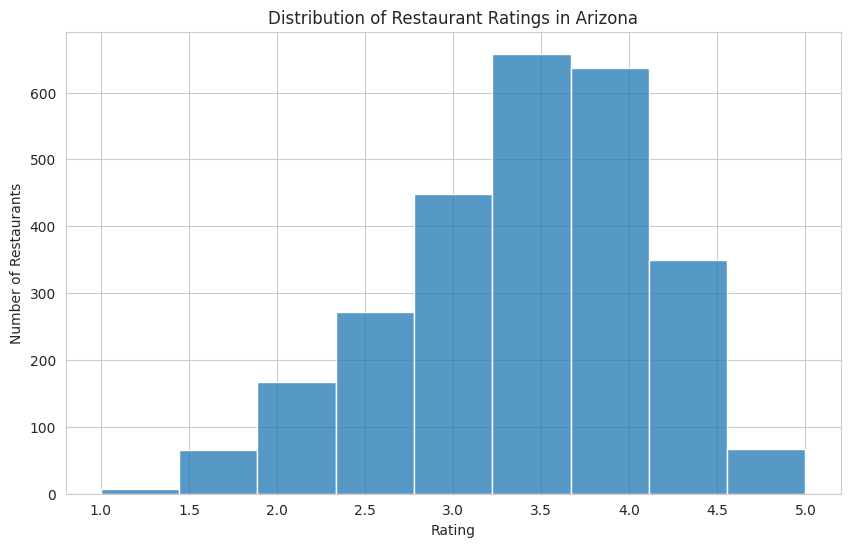

<ipython-input-22-fbe9a1c60799>:28: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x='stars', y='city', data=df_top_cities, order=city_order, ci=None)


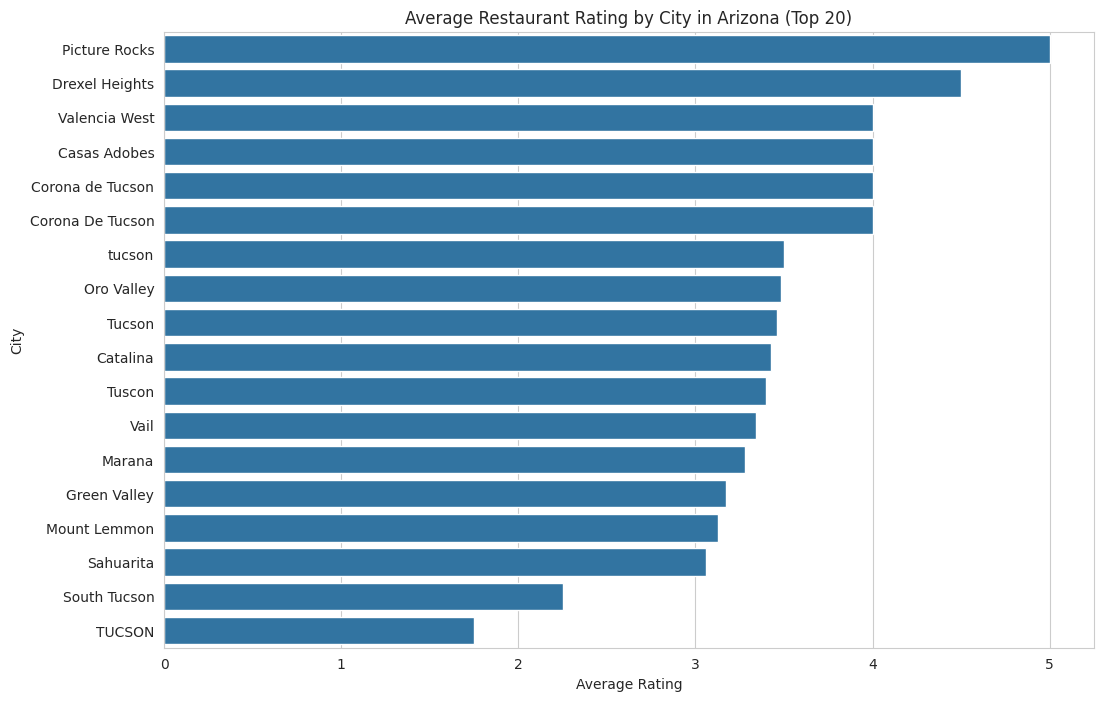

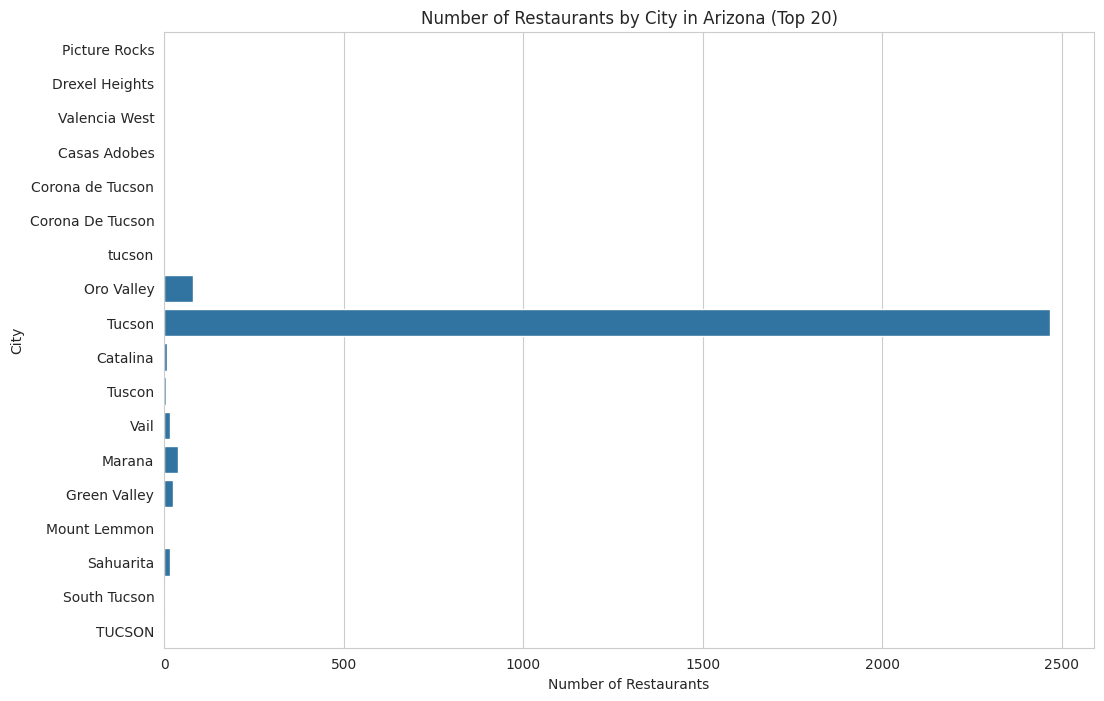

In [22]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load your dataset here if not already loaded
# df = pd.read_json('path_to_your_dataset.json')
# df_restaurants_az = df[df['state'] == 'AZ']

# Now, let's create the plots

# Set the aesthetic style of the plots
sns.set_style("whitegrid")

# Plotting the distribution of restaurant ratings in Arizona
plt.figure(figsize=(10, 6))
sns.histplot(df_restaurants_az['stars'], bins=9, kde=False)
plt.title('Distribution of Restaurant Ratings in Arizona')
plt.xlabel('Rating')
plt.ylabel('Number of Restaurants')
plt.show()

# Plotting the average rating of restaurants by city in Arizona
# For visualization purposes, we will limit to top 20 cities by restaurant count
top_cities_by_count = df_restaurants_az['city'].value_counts().head(20).index
df_top_cities = df_restaurants_az[df_restaurants_az['city'].isin(top_cities_by_count)]
plt.figure(figsize=(12, 8))
city_order = df_top_cities.groupby('city')['stars'].mean().sort_values(ascending=False).index
sns.barplot(x='stars', y='city', data=df_top_cities, order=city_order, ci=None)
plt.title('Average Restaurant Rating by City in Arizona (Top 20)')
plt.xlabel('Average Rating')
plt.ylabel('City')
plt.show()

# Plotting the number of restaurants in the top 20 cities in Arizona
plt.figure(figsize=(12, 8))
sns.countplot(y='city', data=df_top_cities, order=city_order)
plt.title('Number of Restaurants by City in Arizona (Top 20)')
plt.xlabel('Number of Restaurants')
plt.ylabel('City')
plt.show()


In [28]:
# include only businesses in Arizona that are categorized as restaurants
df_restaurants_az = df[(df['state'] == 'AZ') & df['categories'].str.contains('Restaurants', na=False)]
print(df_restaurants_az.head())

                business_id                     name  \
45   wghnIlMb_i5U46HMBGx9ig  China Dragon Restaurant   
78   x9K0RfZaT_zlw6DklBDzjw  Gavi Italian Restaurant   
126  anLQj9AM8vjbcLSIE0iUgg            Papa Murphy's   
132  9C2rpb56aQvW0ViZHK9sPw    Home Plate Sports Pub   
234  Y6heWJJ9AmEL58fZwgi9YQ           Rosati's Pizza   

                             address    city state postal_code   latitude  \
45   1625 W Valencia Rd, Ste 101-103  Tucson    AZ       85746  32.132305   
78    7401 N La Cholla Blvd, Ste 146  Tucson    AZ       85707  32.221667   
126  7250 North La Cholla, Suite 186  Tucson    AZ       85741  32.338572   
132                   4880 E 22nd St  Tucson    AZ       85711  32.206315   
234                    2944 W Ina Rd  Tucson    AZ       85741  32.338724   

      longitude  stars  review_count  is_open  \
45  -110.999985    3.0            23        0   
78  -110.925833    3.5             9        0   
126 -111.010760    4.0            22        1   
132 

# ***Summary after exploration***
Arizona is an ideal demographic region for analysis based on its average restaurant rating in several ways:

Benchmarking: Arizona's average restaurant rating provides a baseline for comparison with other states or regions. If Arizona's average is significantly higher or lower, it might indicate unique regional characteristics that contribute to customer satisfaction or dissatisfaction. This could make Arizona an interesting case study for what factors contribute to restaurant success or failure.

Market Potential: An average rating can reflect the overall customer experience and satisfaction. A higher average rating in Arizona could suggest that restaurants are, on average, meeting or exceeding customer expectations, which might be indicative of a thriving food industry and a potentially lucrative market for new entrants or for existing businesses looking to expand.

Demographic and Cultural Insights: Arizona's demographic diversity, including a mix of urban, suburban, and rural areas as well as a significant Hispanic and Native American population, might contribute to a variety of dining preferences and expectations. Analyzing Arizona could provide insights into how different demographic groups rate restaurants and what types of cuisine or dining experiences are preferred.

Tourism Impact: Arizona is home to several tourist attractions, including the Grand Canyon, which may influence the restaurant industry. Tourists might rate restaurants differently than locals, and a study on Arizona's average ratings could help in understanding the impact of tourism on the restaurant market.

Economic Factors: The economic climate of a region can affect disposable income and dining out frequency. Arizona's average rating may be tied to economic factors that influence how often people eat out and how much they're willing to spend, which in turn could affect ratings.

Growth Trends: Identifying whether the average rating has been improving over time could point to a region that is experiencing growth and improvement in its restaurant industry, making it an attractive area for future investment and research.

In conclusion, using the average restaurant rating as a rationale for selecting Arizona provides an opportunity to explore these different facets, contributing to a holistic understanding of the region's restaurant industry. It is important, however, to consider the average rating as one of many factors in selecting a region for analysis, and to also account for potential biases in the data as previously discussed.

Suitability for Business Questions:
The data selected seems to be highly relevant for analyzing the restaurant industry in Arizona. It includes reviews, which can give insights into customer satisfaction, business data to assess market saturation and competition, and geographical distribution to understand regional market dynamics. This information can be used to answer business questions related to market entry, expansion, customer preference, and service quality.

Appropriateness of Sample Size:
The sample size appears to be substantial for a state-level analysis, particularly in urban areas like Tucson. With over 2,000 restaurants in Tucson alone, there is a rich dataset that should allow for robust statistical analysis. However, some smaller regions have very few restaurants, which might not be enough to draw reliable conclusions about those specific areas.

Potential Data Biases:

The data might be biased in several dimensions:

Geographical Bias: Larger cities like Tucson have more restaurants and potentially more reviewers, which could skew perceptions of quality or standards.

Selection Bias: If the dataset predominantly includes restaurants that are more likely to be reviewed on Yelp (e.g., mid to high-end restaurants), it may not represent the entire spectrum of the restaurant industry, such as fast food or smaller, local eateries.

Rating Normalization: There could be inconsistencies in how ratings are given across different cities or types of restaurants. For instance, a '4-star' restaurant in one city might not equate to a '4-star' in another due to different customer expectations or cultural differences.

Temporal Bias: The data doesn't account for the time when reviews were made. Changes over time, like new management or renovations, can significantly affect a restaurant's quality and customer satisfaction.

Challenges in Data Processing:
Cleaning and Normalization: Ensuring consistency in city names (e.g., 'Tucson' vs. 'TUCSON' vs. 'tucson') will be essential for accurate analysis.

Handling Missing Data: Some entries might lack certain details like hours of operation or specific attributes, which could limit the depth of the analysis.
Data Integration: If combining this dataset with other sources, aligning data formats and resolving discrepancies will be necessary.

Text Analysis: Processing and analyzing textual reviews requires natural language processing (NLP) techniques, which can be complex and computationally intensive.

# **Data Evaluation**

- Purpose of the study:

Consolidating reviews on AZ restaurants to rate aspects of a restaurant.
Generating comments based on the consolidated review ratings.
Establishing market trends based on customer data.
The sufficiency of the data depends on several factors:

Depth and Quality of Reviews: The number of restaurants (2,671 for AZ) may be adequate if there are enough reviews per restaurant to provide a diverse and representative sample of customer opinions. The key is not just how many restaurants are listed, but how many reviews each of those listings has. If there are only a few reviews per restaurant, the data may not be rich enough to accurately reflect customer preferences or to generate meaningful automated comments.
Timeliness of Data: Customer preferences can change rapidly, and data can become outdated. Ensure that the reviews are relatively current to accurately capture the latest market trends.
Statistical Relevance: For statistical analyses and machine learning, the number of data points (in this case, reviews) is crucial. Each additional review provides more information and helps to refine the accuracy of the analysis.
Volume of Data for NLP Tasks: Natural Language Processing (NLP) tasks, such as generating comments automatically based on review sentiments, require a substantial amount of textual data to train models effectively.
Overall Market Data: It's important to know what proportion of the total restaurant market in Arizona is covered by these 2,671 restaurants. If they represent a substantial portion of the market, the insights gained could be very valuable.
Considering these factors, if each of the 2,671 restaurants has a significant number of reviews that are recent and cover a wide range of experiences, the dataset could be considered sufficient for the analysis purposes. However, if the reviews are sparse, outdated, or not representative, then additional data is needed to confidently establish market trends and generate automated comments.

# **Preliminary Data Exploration**
- topic1:Italian Cuisine Experience
- topic2:Tucson Dining and Atmosphere
- topic3:Service and Dining Out
- topic4:Breakfast and Coffee Shops
- topic5:Ambiance and Enjoyment
- topic6:Japanese Food Dining Experience
- topic7:Customer Service During COVID
- topic8:Food Quality and Taste
- topic9:Casual Dining Favorites
## **Comment**

Despite obtaining 10 categories, we believe that some may not have been trained sufficiently, which could be due to an inadequate number of training iterations. Additionally, we noticed a lack of categories related to negative reviews; most categories are about positive aspects such as good service attitude or the types of restaurants. Therefore, we think it would be beneficial to run a topic model using only 1-star reviews in the future to attempt to identify categories that reflect reasons for negative feedback.

In [24]:
import pandas as pd
import numpy as np
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from textblob import TextBlob

nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

def preprocess_text(text):

    tokens = word_tokenize(text)

    stop_words = set(stopwords.words('english'))
    filtered_tokens = [word for word in tokens if word.lower() not in stop_words]

    lemmatizer = WordNetLemmatizer()
    lemmatized_tokens = [lemmatizer.lemmatize(word) for word in filtered_tokens]

    preprocessed_text = ' '.join(lemmatized_tokens)
    return preprocessed_text

filtered_reviews_after_2019['preprocessed_text'] = filtered_reviews_after_2019['text'].apply(preprocess_text)

vectorizer = TfidfVectorizer(max_df=0.8, min_df=5, max_features=1000)
X = vectorizer.fit_transform(filtered_reviews_after_2019['preprocessed_text'])

num_topics = 5
lda = LatentDirichletAllocation(n_components=num_topics, max_iter=10, learning_method='online', random_state=42)
lda.fit(X)

def display_topics(model, feature_names, no_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print(f"Topic {topic_idx + 1}:")
        print(" ".join([feature_names[i] for i in topic.argsort()[:-no_top_words - 1:-1]]))

no_top_words = 10
feature_names = vectorizer.get_feature_names_out()
display_topics(lda, feature_names, no_top_words)

def sentiment_analysis(text):
    blob = TextBlob(text)
    sentiment_score = blob.sentiment.polarity
    return sentiment_score

filtered_reviews_after_2019['sentiment_score'] = filtered_reviews_after_2019['preprocessed_text'].apply(sentiment_analysis)

topic_sentiment_scores = []
for index, topic in enumerate(lda.components_):
    topic_reviews = filtered_reviews_after_2019.iloc[np.argmax(lda.transform(X), axis=1) == index]
    mean_sentiment_score = topic_reviews['sentiment_score'].mean()
    topic_sentiment_scores.append(mean_sentiment_score)

for i, score in enumerate(topic_sentiment_scores):
    print(f"Sentiment score for Topic {i + 1}: {score}")


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
<ipython-input-24-537ce651b7c7>:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_reviews_after_2019['preprocessed_text'] = filtered_reviews_after_2019['text'].apply(preprocess_text)


Topic 1:
food time order service table minute get back would place
Topic 2:
pizza good chicken food salad place ordered like sauce great
Topic 3:
great food place service amazing always best friendly tucson love
Topic 4:
breakfast great good delicious place food coffee egg vegan option
Topic 5:
taco burger salsa burrito rib bean good cheese bbq fry


<ipython-input-24-537ce651b7c7>:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_reviews_after_2019['sentiment_score'] = filtered_reviews_after_2019['preprocessed_text'].apply(sentiment_analysis)


Sentiment score for Topic 1: 0.17583449126626313
Sentiment score for Topic 2: 0.27322362490375146
Sentiment score for Topic 3: 0.4860001372089366
Sentiment score for Topic 4: 0.3920137580291884
Sentiment score for Topic 5: 0.3478393509992641


In [25]:
topic_keywords = {
    'service': ['service', 'waiter', 'staff', 'attentive', 'slow', 'unresponsive', 'rude'],
    'clean': ['clean', 'hygienic', 'sanitary', 'tidy', 'dirty', 'messy', 'unclean'],
    'food_quality': ['food', 'quality', 'delicious', 'tasty', 'bad', 'poor', 'unappetizing'],
    'attitude': ['attitude', 'friendly', 'polite', 'courteous','unfriendly', 'impolite', 'rude'],
    'speed': ['speed', 'fast', 'quick', 'efficient', 'slow', 'delayed', 'tardy']
}

def identify_topics(text):
    topics = []
    for topic, keywords in topic_keywords.items():
        if any(keyword in text for keyword in keywords):
            topics.append(topic)
    return topics

filtered_reviews_after_2019['topics'] = filtered_reviews_after_2019['preprocessed_text'].apply(identify_topics)

topic_sentiment_scores = {topic: [] for topic in topic_keywords.keys()}
for topic in topic_keywords.keys():
    topic_reviews = filtered_reviews_after_2019[filtered_reviews_after_2019['topics'].apply(lambda x: topic in x)]
    topic_reviews.loc[:, 'sentiment_score'] = topic_reviews['preprocessed_text'].apply(sentiment_analysis)
    # topic_reviews['sentiment_score'] = topic_reviews['preprocessed_text'].apply(sentiment_analysis)
    mean_sentiment_score = topic_reviews['sentiment_score'].mean()
    topic_sentiment_scores[topic].append(mean_sentiment_score)

for topic, scores in topic_sentiment_scores.items():
    print(f"Sentiment score for {topic.capitalize()}: {scores[0]}")


<ipython-input-25-2bd838e12327>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_reviews_after_2019['topics'] = filtered_reviews_after_2019['preprocessed_text'].apply(identify_topics)
<ipython-input-25-2bd838e12327>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  topic_reviews.loc[:, 'sentiment_score'] = topic_reviews['preprocessed_text'].apply(sentiment_analysis)


Sentiment score for Service: 0.3017047106048867
Sentiment score for Clean: 0.2519398670855401
Sentiment score for Food_quality: 0.3062266347667108
Sentiment score for Attitude: 0.29650827032182814
Sentiment score for Speed: 0.2967650492475531


In [33]:

unique_business_ids_in_reviews = filtered_reviews_after_2019['business_id'].unique()

matched_businesses = df_restaurants_az[df_restaurants_az['business_id'].isin(unique_business_ids_in_reviews)]

matched_restaurant_names = matched_businesses['name'].unique()

print(matched_restaurant_names)


['Sher-e-Punjab' 'Taqueria Pico De Gallo' 'Persian Room Fine Dining'
 'Prep & Pastry' 'Barrio Brewing' "AJ's Fine Foods" 'Kung Fu Noodle'
 "Ghini's French Caffe" 'Casino Del Sol' 'BK Tacos' 'Aqui Con El Nene'
 'Maynards' 'Street- Taco and Beer Co.' 'El Merendero' "Caruso's" 'Penca'
 'Trident Grill' 'Fiamme Pizza' 'Le Rendez-vous' 'El Charro Cafe'
 "St Mary's Mexican Food" 'Fresco Pizzeria' "Blake's Lotaburger"
 'Raijin Ramen' 'Village Bakehouse' 'Postino Grant' 'No Anchovies'
 'Charro Steak & Del Rey' 'Ba-Dar' 'Falora' "D's Island Grill JA"
 'La Hacienda Restaurant' 'The Parish' 'Tumerico' 'First Watch'
 'Pastiche Modern Eatery' 'Hotel Congress'
 'El Conquistador Tucson, A Hilton Resort' 'El Sur Restaurant'
 'Welcome Diner' 'Kababeque Indian Grill' '4 Seasons'
 'Contigo Latin Kitchen' "Taqueria Juanito's" 'La Indita' 'Sushi Garden'
 "Mr. An's Teppan Steak & Seafood Sushi Bar" 'Takamatsu' 'Ikkyu'
 'Epic Cafe' 'Locale Neighborhood Italian' 'LongHorn Steakhouse'
 "Opa's Best Greek America

In [34]:
def calculate_sentiment_scores(business_name, df_businesses, df_reviews):
    # Find the business_id for the given business_name
    business_id = df_restaurants_az[df_restaurants_az['name'] == business_name]['business_id'].iloc[0]

    # Filter reviews for the business_id
    business_reviews = filtered_reviews_after_2019[filtered_reviews_after_2019['business_id'] == business_id]

    # Check if there are any reviews for the business
    if business_reviews.empty:
        print(f"No reviews found for {business_name}.")
        return

    # Apply topic identification
    business_reviews['topics'] = business_reviews['text'].apply(identify_topics)

    # Initialize a dictionary to hold sentiment scores
    topic_sentiment_scores = {topic: [] for topic in topic_keywords.keys()}

    # Calculate sentiment scores for each topic
    for topic in topic_keywords.keys():
        # Filter reviews that mention the topic
        topic_reviews = business_reviews[business_reviews['topics'].apply(lambda x: topic in x)]

        # If there are no reviews for this topic, skip to the next one
        if topic_reviews.empty:
            print(f"No reviews for the topic '{topic}' for {business_name}.")
            continue

        # Calculate sentiment scores for the filtered reviews
        topic_reviews['sentiment_score'] = topic_reviews['text'].apply(sentiment_analysis)
        mean_sentiment_score = topic_reviews['sentiment_score'].mean()
        topic_sentiment_scores[topic].append(mean_sentiment_score)

    # Print sentiment scores
    for topic, scores in topic_sentiment_scores.items():
        if scores:  # Check if the list is not empty
            print(f"Sentiment score for {topic.capitalize()}: {scores[0]}")
        else:
            print(f"No sentiment score for {topic.capitalize()} due to no relevant reviews.")

# Example usage:df_restaurants_az
calculate_sentiment_scores("Sher-e-Punjab", df_restaurants_az, filtered_reviews_after_2019)


<ipython-input-34-de35a3c718d6>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  business_reviews['topics'] = business_reviews['text'].apply(identify_topics)
<ipython-input-34-de35a3c718d6>:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  topic_reviews['sentiment_score'] = topic_reviews['text'].apply(sentiment_analysis)


Sentiment score for Service: 0.25242813099510714
Sentiment score for Clean: 0.3224231076728023
Sentiment score for Food_quality: 0.2956334212593125
Sentiment score for Attitude: 0.3307114765167133
Sentiment score for Speed: 0.2810509418996228


# **Proposed Solution**

For our project, we plan to employ a combination of machine learning and unstructured data analytics methods to address our current challenges in evaluating restaurant reviews across multiple dimensions, such as cleanliness, service quality, taste of food, speed of service, pricing, and ambiance. The proposed solution includes:

**Topic Modeling**: Utilize Latent Dirichlet Allocation (LDA) to identify themes across reviews, which will help us categorize feedback into distinct aspects of restaurant operations.

**Sentiment Analysi**s: Apply sentiment analysis algorithms to assess the tone (positive, negative, neutral) of reviews related to identified topics. This will enable us to quantify perceptions of each restaurant aspect.

**Natural Language Processing (NLP)**: Implement NLP techniques to extract and analyze key phrases and sentiments from unstructured text data. This will aid in understanding specific customer feedback on each identified topic.

**Supervised Machine Learning**: Develop predictive models using supervised learning techniques to rate each aspect of a restaurant based on review text. This could involve regression analysis or classification models to predict aspect scores.

In [ ]:
!pip install jupyter
!pip install nbconvert
!jupyter nbconvert "/content/drive/MyDrive/ProjectEDA_Finovators.ipynb" --to html

[NbConvertApp] WARNING | pattern '/content/drive/MyDrive/ProjectEDA_Finovators.ipynb' matched no files
This application is used to convert notebook files (*.ipynb)
        to various other formats.


Options
The options below are convenience aliases to configurable class-options,
as listed in the "Equivalent to" description-line of the aliases.
To see all configurable class-options for some <cmd>, use:
    <cmd> --help-all

--debug
    set log level to logging.DEBUG (maximize logging output)
    Equivalent to: [--Application.log_level=10]
--show-config
    Show the application's configuration (human-readable format)
    Equivalent to: [--Application.show_config=True]
--show-config-json
    Show the application's configuration (json format)
    Equivalent to: [--Application.show_config_json=True]
--generate-config
    generate default config file
    Equivalent to: [--JupyterApp.generate_config=True]
-y
    Answer yes to any questions instead of prompting.
    Equivalent to: [--JupyterA